In [266]:
import pandas as pd # for data manipulation
import numpy as np  # for numeric operations
from sklearn.feature_extraction.text import TfidfVectorizer # for text to vector conversion
from sklearn.model_selection import train_test_split # for splitting data
import re                    # for regex operations
import scipy.sparse as sp # for sparse matrix operations
from dataclasses import dataclass
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_recall_curve, auc
import seaborn as sns
import os





## Preprocess

In [267]:
df = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['label', 'message'])
#df.head()

# data cleaning function

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    #remove html tags
    text = re.sub(r'<.*?>', '', text)
    #remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    #remove emails
    text = re.sub(r'\S+@\S+', '', text)
    #remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_message'] = df['message'].apply(clean_text)
#df.head()

# encode labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})




#


## Vectorize
Vectorizing using TF-IDF(Term Frequency - Inverse Document Frequency)


In [268]:
# Vectorize the messages using TF-IDF
vectorizer = TfidfVectorizer(
    # stop_words='english',
    ngram_range=(1, 2),
    max_df=0.95,
    min_df=2
)


X_tfidf = vectorizer.fit_transform(df['cleaned_message'])
y = df['label'].values

print("TF-IDF matrix shape:", X_tfidf.shape)

# Convert to binary inorder to use with NSA
tau = 0.05
X_binary = (X_tfidf >= tau).astype(np.uint8)

#basic diagnostics
density = X_binary.nnz / (X_binary.shape[0] * X_binary.shape[1])
print(f"Binary density: {density:6f}")

#

TF-IDF matrix shape: (5572, 14738)
Binary density: 0.001315


- as expected we got total of 5572 messages
- we have a feature space of 14738 with 0.0013 density

## Train and predict NSA

In [269]:
# seperate self(ham) and non-self (spam) 
X_ham = X_binary[y == 0]
X_spam = X_binary[y == 1]

print(f"Ham matrix shape: {X_ham.shape}")
print(f"Spam matrix shape: {X_spam.shape}")

Ham matrix shape: (4825, 14738)
Spam matrix shape: (747, 14738)


In [270]:
# split self data into train and test sets
X_ham_train, X_ham_test = train_test_split(X_ham, test_size=0.2, random_state=42)

print(f"Ham train shape: {X_ham_train.shape}")
print(f"Ham test shape: {X_ham_test.shape}")

Ham train shape: (3860, 14738)
Ham test shape: (965, 14738)


In [271]:
@dataclass
# we decide to implement NSA using r-overlap matching rule between message and detector 

class Detector:
    idx: np.ndarray #active bits indices
    radius: int   #required overlap 

class VDetectorNSA_Binary:

    def __init__(self,
                 k: int,  #number of detectors
                 r_min: int, #min radius
                 r_max: int, #max radius
                 max_detectors: int, #maximum number of detectors to generate
                 max_tries: int, #maximum number of tries to generate detectors
                 batch_size: int, #batch size for detector generation
                 sampling: str = 'antiprofile', #sampling method
                 random_state: int = 42 #random seed
                 ):
        self.k = k
        self.r_min = r_min
        self.r_max = r_max
        self.max_detectors = max_detectors
        self.max_tries = max_tries
        self.batch_size = batch_size 
        self.sampling = sampling
        self.random_state = random_state

        self.dim = None
        self.detectors : list[Detector] = []
        self.p_detect = None

    def _build_antiprofile_probs(self, X_ham_train: sp.csr_matrix) -> np.ndarray:
        """Build antiprofile sampling probabilities from self data."""
        #calculate feature frequencies
        assert sp.issparse(X_ham_train), "Input data must be a sparse matrix."
        p_ham = (X_ham_train.sum(axis=0) / X_ham_train.shape[0]).A1
        p = np.clip(1.0 - p_ham, 1e-8, 1.0)
        self.p_detect = p / p.sum()  # avoid zero probabilities
    
    def _sample_indices(self):
        if self.sampling == 'antiprofile':
            return np.sort(np.random.choice(
                self.dim, size=min(self.k, self.dim), replace=False, p=self.p_detect))
        else:  
            return np.sort(np.random.choice(
                self.dim, size=min(self.k, self.dim), replace=False))
        
    @staticmethod
    def _vec_from_idx(idx, dim: int) -> sp.csr_matrix:
        data = np.ones(len(idx), dtype=np.uint8)
        rows = np.zeros(len(idx), dtype=np.int32)
        return sp.csr_matrix((data, (rows, idx)), shape=(1, dim))
    
    @staticmethod
    def _max_overlap(X_binary: sp.csr_matrix, detector_vec: sp.csr_matrix, batch_size: int) -> np.ndarray:
        """Compute maximum overlap between each row in X_binary and the detector vector."""
        n = X_binary.shape[0]
        best = 0
        for s in range(0, n, batch_size):
            e = min(s + batch_size, n)
            overlap = (X_binary[s:e] @ detector_vec.T).A.ravel()
            if overlap.size:
                m = int(overlap.max())
                if m > best:
                    best = m

        return best
    
    def fit(self, X_ham_train: sp.csr_matrix):
        assert sp.issparse(X_ham_train), "Input data must be a sparse matrix."
        np.random.seed(self.random_state)

        self.dim = X_ham_train.shape[1]
        if self.sampling == 'antiprofile':
            self._build_antiprofile_probs(X_ham_train)
        
        accepted, tries = 0, 0
        while accepted < self.max_detectors and tries < self.max_tries:
            tries += 1
            idx = self._sample_indices()
            det_vec = self._vec_from_idx(idx, self.dim)

            m_o = self._max_overlap(X_ham_train, det_vec, self.batch_size)
            r = min(self.r_max, max(self.r_min, m_o -1))

            if r < self.r_min:
                continue # too close to self data

            # ensure no ham at or above r
            if m_o >= r:
                pass

            self.detectors.append(Detector(idx=idx, radius=r))
            accepted += 1

        return self

    def predict(self, X_bin: sp, k_hits: int = 1, return_score: bool = False) -> np.ndarray:
        """Predict if samples in X_bin are non-self (spam) or self (ham)."""
        assert self.detectors, "The model has not been fitted yet."
        n = X_bin.shape[0]
        predictions = np.zeros(n, dtype=np.uint8)  # default to self (ham)

        # build detector matrix once for 
        rows, cols, data, r_list = [], [], [], []
        for i, det in enumerate(self.detectors):
            cols.extend(det.idx.tolist())
            rows.extend([i] * len(det.idx))
            data.extend([1] * len(det.idx))
            r_list.append(det.radius)
        det_matrix = sp.csr_matrix((data, (rows, cols)), shape=(len(self.detectors), self.dim))
        r_array = np.array(r_list)

        batch_size = self.batch_size
        scores = np.zeros(n, dtype=np.int32) if return_score else None

        for start in range(0, n, self.batch_size):
            end = min(start + self.batch_size, n)
            overlaps = (X_bin[start:end] @ det_matrix.T).A
            hits = (overlaps >= r_array)
            if return_score:
                scores[start:end] = hits.sum(axis=1)
            if k_hits == 1:
                predictions[start:end] = hits.any(axis=1).astype(np.uint8)
            else:
                predictions[start:end] = (hits.sum(axis=1) >= k_hits).astype(np.uint8)
        return predictions if not return_score else (predictions, scores)
                                       




## Evaluate

In [272]:
nsa = VDetectorNSA_Binary(
    k=60,
    r_min=2, r_max=8,
    max_detectors=2000,
    max_tries=50000,
    sampling="antiprofile",
    random_state=42,
    batch_size=1000
).fit(X_ham_train)


In [273]:
# build eval set: ham_test + all spam
X_eval = vstack([X_ham_test, X_spam])
y_eval = np.hstack([
    np.zeros(X_ham_test.shape[0], dtype=np.uint8),
    np.ones(X_spam.shape[0], dtype=np.uint8)
])



### Visualization of Evaluation

In [274]:
# confusion matrix and classification report

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, labels: tuple = ('Ham', 'Spam'), title: str = 'Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100

    labels_text = np.array(
        [f"{count}\n({percent:.2f}%)" for count, percent in zip(cm.flatten(), cm_percent.flatten())]
    )

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=labels_text.reshape(cm.shape), fmt='', cmap='Blues',
                 xticklabels=[f"Pred{l}" for l in labels], 
                 yticklabels=[f"True{l}" for l in labels])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_classification_report(y_true: np.ndarray, y_pred: np.ndarray, title: str = 'Classification Report'):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).T

    plt.figure(figsize=(8, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Greens', fmt='.2f')
    plt.title(title)
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.show()

# coverage curve and precision-recall curve functions

def plot_coverage_curve(nsa: VDetectorNSA_Binary, X_eval: sp.csr_matrix, y_eval: np.ndarray, k_hits: int, step: int = 100):
    '''Plot recall vs number of detectors used'''
    n_total = len(nsa.detectors)
    steps = np.arange(step, n_total +1, step)
    recalls = []

    for n in steps:
        subset = VDetectorNSA_Binary(
            k=nsa.k,
            r_min=nsa.r_min,
            r_max=nsa.r_max,
            max_detectors=n,
            max_tries=nsa.max_tries,
            sampling=nsa.sampling,
            random_state=nsa.random_state,
            batch_size=nsa.batch_size
        )
        subset.dim = nsa.dim
        subset.detectors = nsa.detectors[:n]
        y_pred = subset.predict(X_eval, k_hits=k_hits)
        recalls.append(recall_score(y_eval, y_pred, pos_label=1))

    plt.figure(figsize=(8, 6))
    plt.plot(steps, recalls, marker='o', linewidth=2)
    plt.title(f"Recall vs Number of Detectors (k_hits={k_hits})")
    plt.xlabel('Number of Detectors')
    plt.ylabel('Recall')
    plt.grid()
    plt.show()

def plot_precision_recall_curve(nsa: VDetectorNSA_Binary, X_eval: sp.csr_matrix, y_eval: np.ndarray, k_hits: int):
    '''Plot Precision-recall curve using detector hit counts as scores'''
    y_pred, scores = nsa.predict(X_eval, k_hits=k_hits, return_score=True)
    prec, rec, _ = precision_recall_curve(y_eval, scores)
    pr_auc = auc(rec, prec)

    plt.figure(figsize=(8, 6))
    plt.plot(rec, prec, label=f'PR Curve (AUC={pr_auc:.2f})', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (k_hits={k_hits})')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

=== Evaluation with k_hits=1 ===


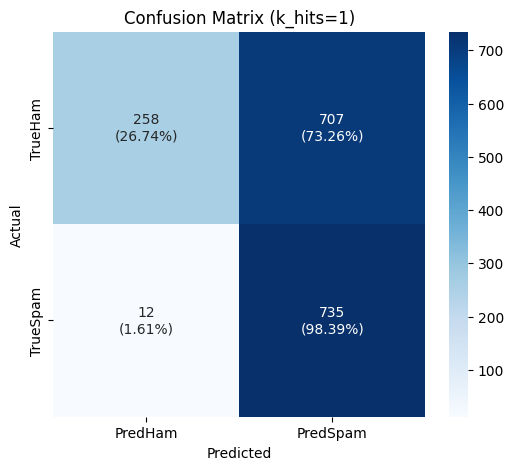

              precision    recall  f1-score   support

         ham       0.96      0.27      0.42       965
        spam       0.51      0.98      0.67       747

    accuracy                           0.58      1712
   macro avg       0.73      0.63      0.54      1712
weighted avg       0.76      0.58      0.53      1712



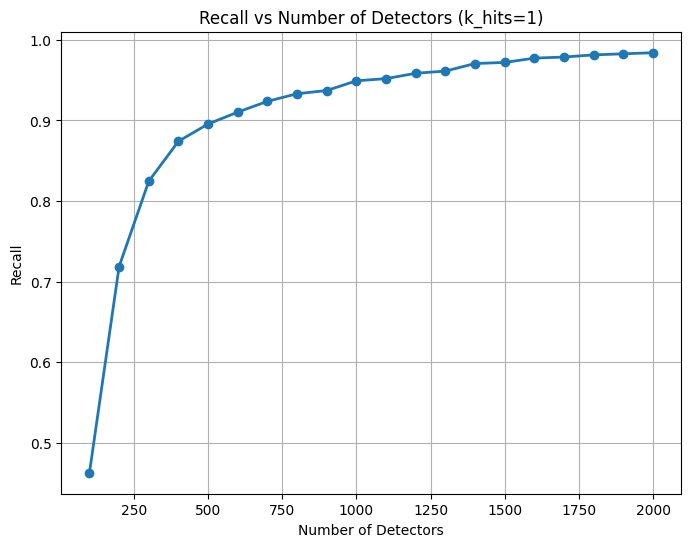

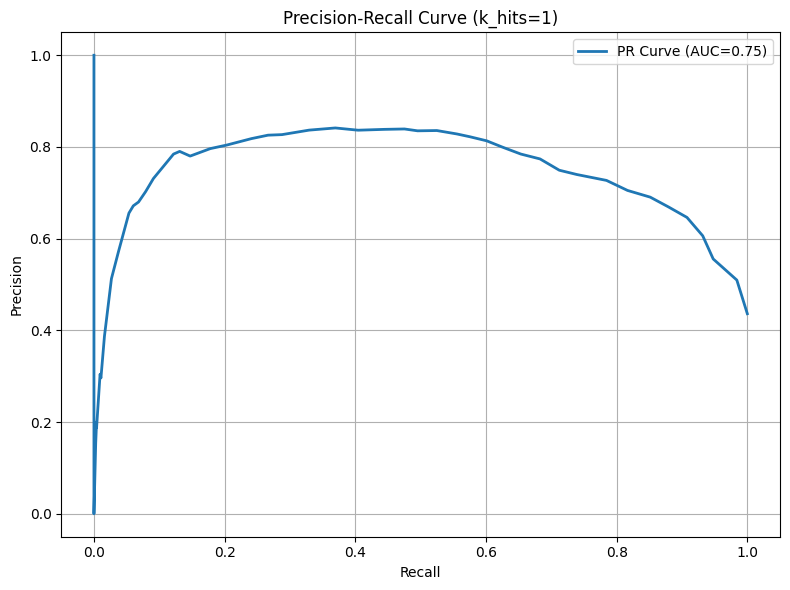

=== Evaluation with k_hits=2 ===


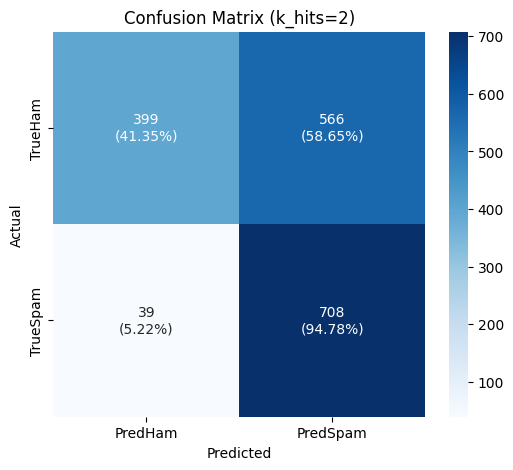

              precision    recall  f1-score   support

         ham       0.91      0.41      0.57       965
        spam       0.56      0.95      0.70       747

    accuracy                           0.65      1712
   macro avg       0.73      0.68      0.63      1712
weighted avg       0.76      0.65      0.63      1712



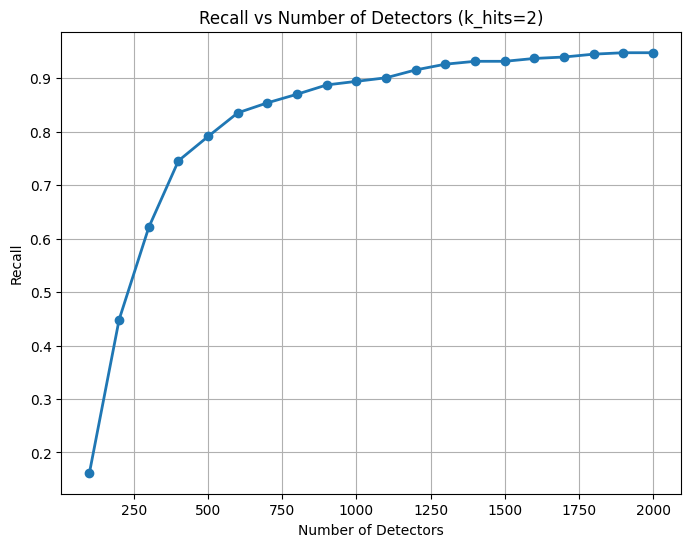

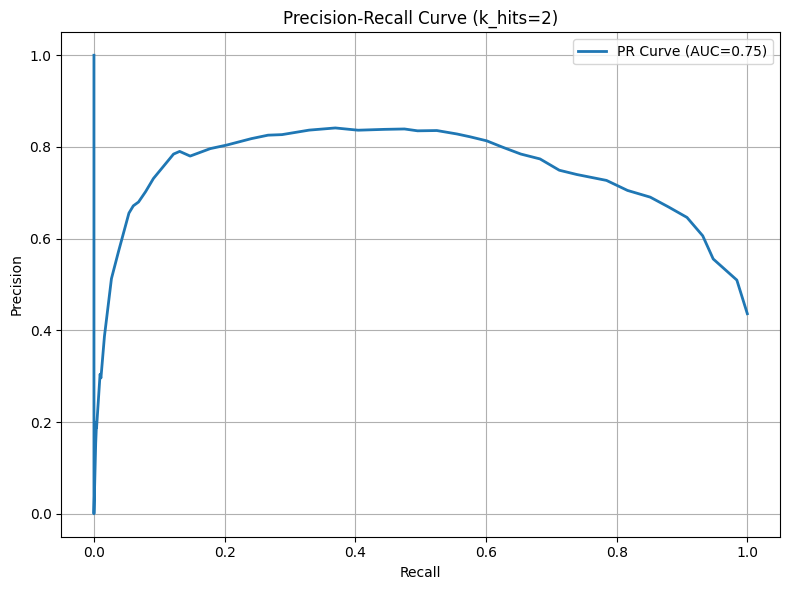

=== Evaluation with k_hits=3 ===


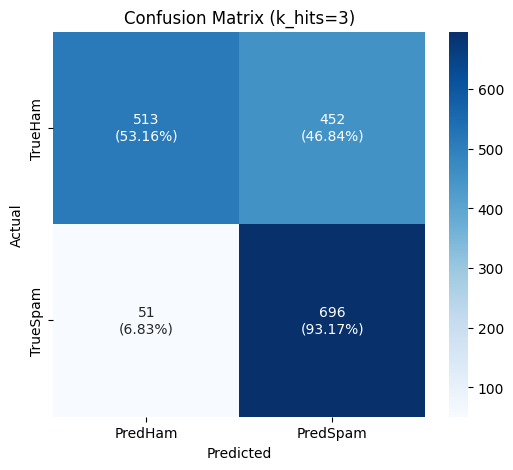

              precision    recall  f1-score   support

         ham       0.91      0.53      0.67       965
        spam       0.61      0.93      0.73       747

    accuracy                           0.71      1712
   macro avg       0.76      0.73      0.70      1712
weighted avg       0.78      0.71      0.70      1712



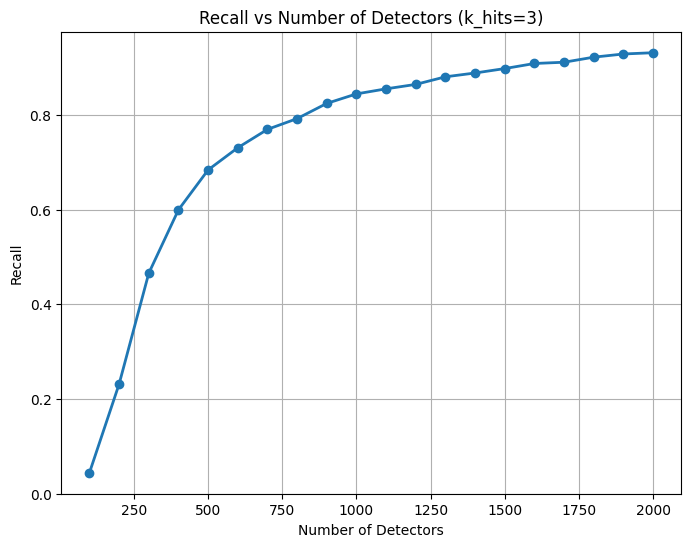

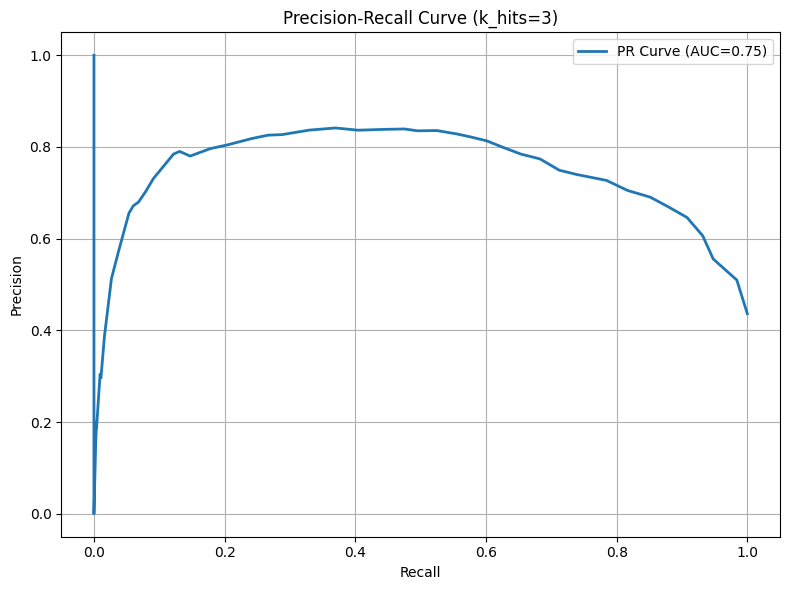

In [275]:
for hits in (1, 2, 3):
    y_pred = nsa.predict(X_eval, k_hits=hits)
    print(f"=== Evaluation with k_hits={hits} ===")
    plot_confusion_matrix(y_eval, y_pred, title=f'Confusion Matrix (k_hits={hits})')
    # plot_classification_report(y_eval, y_pred, title=f'Classification Report (k_hits={hits})')
    print(classification_report(y_eval, y_pred, target_names=["ham", "spam"]))
    plot_coverage_curve(nsa, X_eval, y_eval, k_hits=hits)
    plot_precision_recall_curve(nsa, X_eval, y_eval, k_hits=hits)